# Deep Learning Introduction

**Лектор:** Тришин Владимир Евгеньевич, ООО Инфорион

**Telegram:** @trishin_v </br>
**Mail:** v.trishin@inforion.ru

## Зачем нужны нейронные сети?

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl"...
Generating image for seed 403 ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


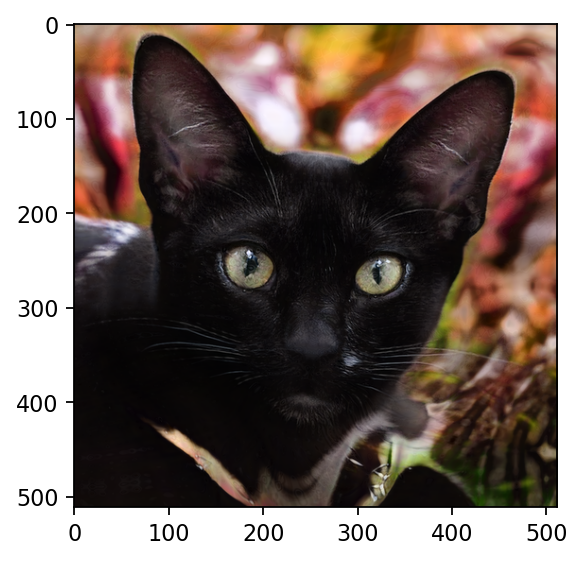

In [1]:
from magic import *

pet = generate_pet(403)
plt.imshow(pet);
plt.grid(False)

## ImageNet Эффект

![](img/hard/imagenet-2.png)

## Сети прямого распространения

$$
x_{n+1} = f_n(W_n \cdot x_n)
$$

$x_n$ - выход n-ного слоя сети

$W_n$ - матрица весов n-ного слоя сети

$f_n$ - функция активации n-ного слоя сети

![](img/hard/feedforward.png)

#### Примеры функций активации:

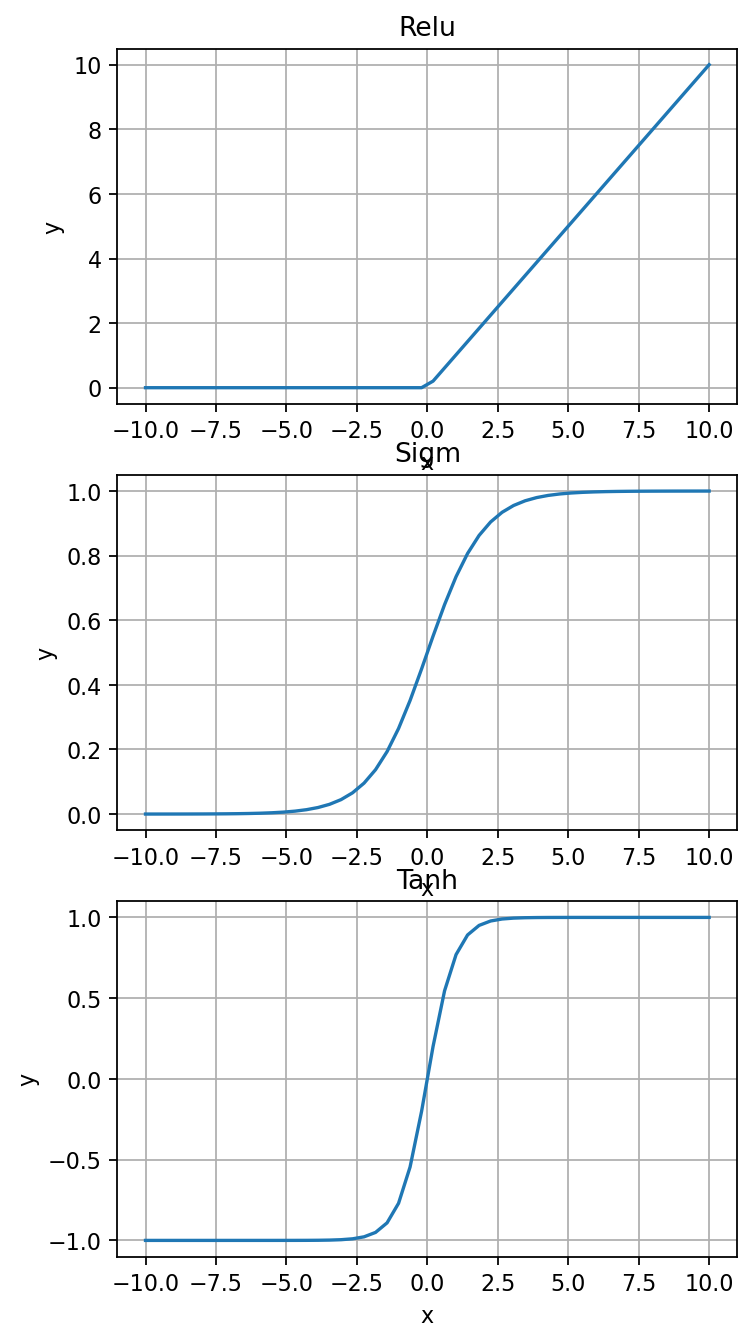

In [1]:
from prelude import *

def relu(x):
    return np.clip(x, a_min=0, a_max=None)

def sigm(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

fig, ax = plt.subplots(3)
fig.set_size_inches((5, 10))

x = np.linspace(-10, 10)
plt.subplot(311, title='Relu', xlabel='x', ylabel='y')
plt.plot(x, relu(x))
plt.subplot(312, title='Sigm', xlabel='x', ylabel='y')
plt.plot(x, sigm(x))
plt.subplot(313, title='Tanh', xlabel='x', ylabel='y')
plt.plot(x, tanh(x))

## Многообразия

> Множество точек в пространстве высокой размерности, которое можно хорошо аппроксимировать, вводя в рассмотрение лишь небольшое число степеней свободы.

### Примеры:

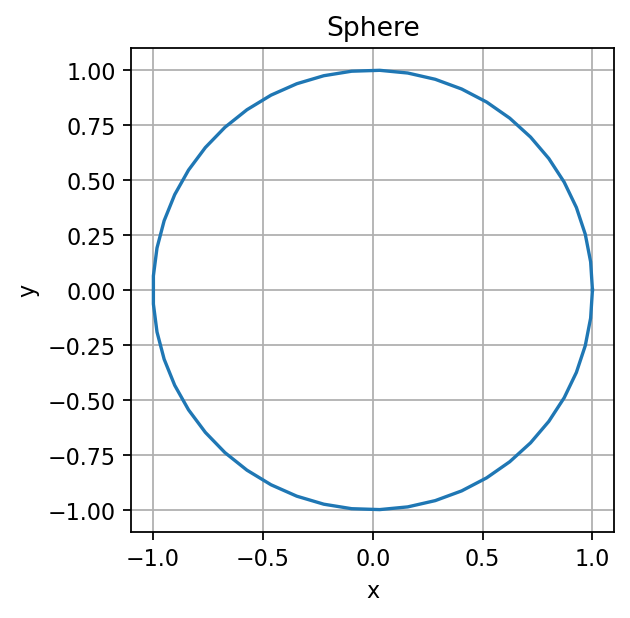

In [3]:
ax = plt.axes(title='Sphere', aspect='equal', xlabel='x', ylabel='y')
fi = np.linspace(0, 2*np.pi)
ax.plot(np.cos(fi), np.sin(fi));


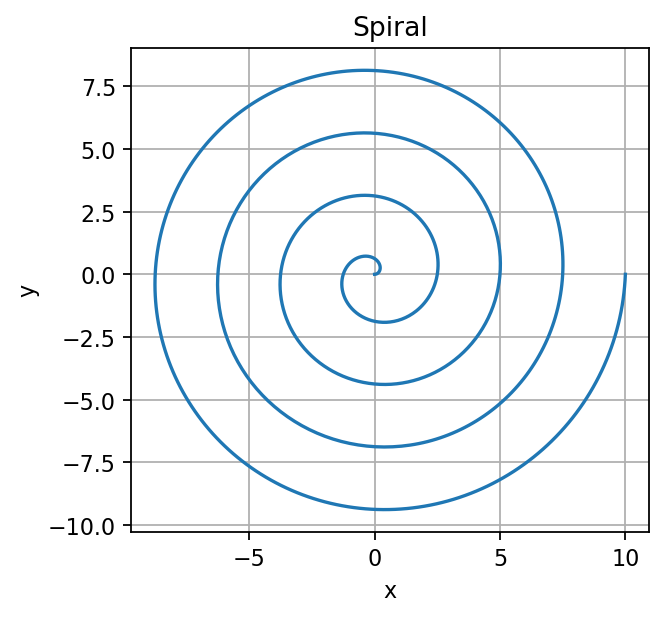

In [4]:
ax = plt.axes(title='Spiral', aspect='equal', xlabel='x', ylabel='y')
p = np.linspace(0, 10, num=1000)
fi = np.linspace(0, np.pi*8, num=1000)
ax.plot(p * np.cos(fi), p * np.sin(fi));

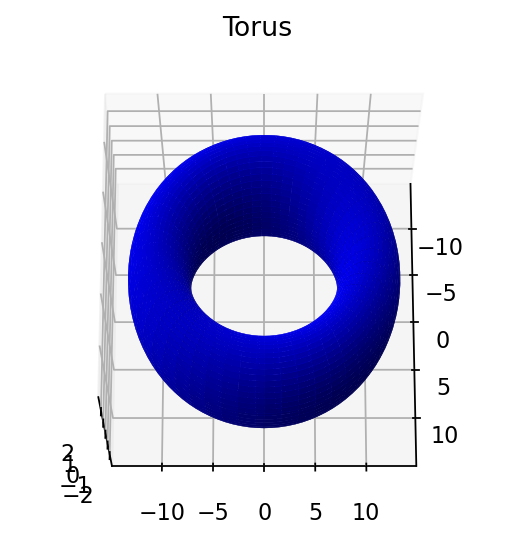

In [5]:
ax = plt.axes(projection='3d', title='Torus')

def torus(precision, c, a):
    U = np.linspace(0, 2*np.pi, precision)
    V = np.linspace(0, 2*np.pi, precision)
    U, V = np.meshgrid(U, V)
    X = (c+a*np.cos(V))*np.cos(U)
    Y = (c+a*np.cos(V))*np.sin(U)
    Z = a*np.sin(V)
    return X, Y, Z
    
ax.plot_surface(*torus(100, 10, 3), antialiased=True, color='blue')
ax.view_init(70, 0);

## Convolution Network's (Светрочные сети)

![](img/hard/convolution_encoder.jpeg)

![](img/hard/convolution.png)

![](img/hard/convolution-stride-padding.png)

### Классификация

#### VGG16

![](img/hard/vgg16.png)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Sequential, Model
from tensorflow.keras.regularizers import L2

class Conv2DBN(Layer):
    def __init__(self, *args, l2=0.0005, drop=0.3, padding='same', activation='relu', **kwargs):
        super().__init__()
        self.drop = drop
        self.conv = Conv2D(
            *args, **kwargs,
            padding=padding,
            activation=activation,
            kernel_regularizer=L2(l2)
        )
        self.bn = BatchNormalization()
        self.drop = Dropout(drop)
     
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.drop(x)

class VGG16(Model):
    def __init__(self, out_classes, l2=0.0005):
        super().__init__()
        
        self.encoder = Sequential([
            Conv2DBN(64, (3, 3)),
            Conv2DBN(64, (3, 3), drop=0),
            MaxPool2D((2, 2), strides=(2, 2)),

            Conv2DBN(128, (3, 3)),
            Conv2DBN(128, (3, 3), drop=0),
            MaxPool2D((2, 2), strides=(2, 2)),

            Conv2DBN(256, (3, 3)),
            Conv2DBN(256, (3, 3)),
            Conv2DBN(256, (3, 3), drop=0),
            MaxPool2D((2, 2), strides=(2, 2)),

            Conv2DBN(512, (3, 3)),
            Conv2DBN(512, (3, 3)),
            Conv2DBN(512, (3, 3), drop=0),
            MaxPool2D((2, 2), strides=(2, 2)),

            Conv2DBN(512, (3, 3)),
            Conv2DBN(512, (3, 3)),
            Conv2DBN(512, (3, 3), drop=0),
            MaxPool2D((2, 2), strides=(2, 2)),
            Flatten()
        ]) 

        self.ff = Sequential([
            Dense(512, activation='relu'),
            Dense(out_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        return self.ff(x)

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

CLASSES_COUNT = 10

y_train = tf.one_hot(y_train[:, 0], CLASSES_COUNT, axis=1)
y_test = tf.one_hot(y_test[:, 0], CLASSES_COUNT, axis=1)

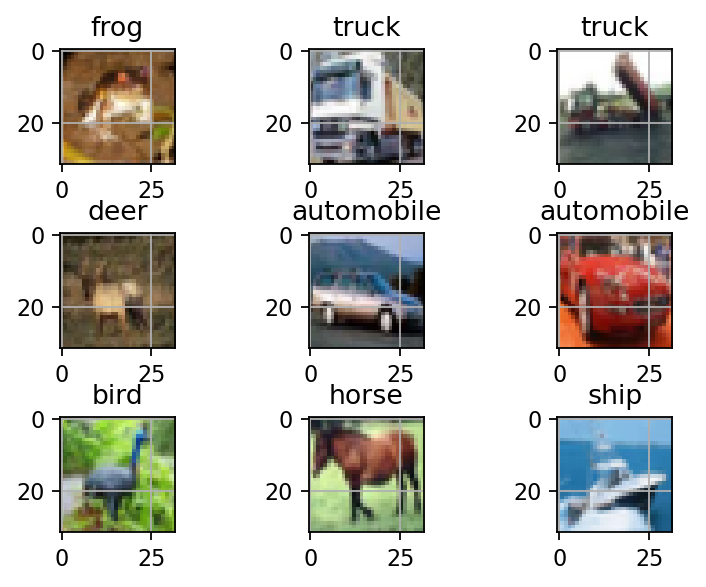

In [8]:
def plot_images(x, y, n=3, offset=0):
    f, ax = plt.subplots(n, n)
    for i in range(n*n):
        x, y = x_train[i + offset], y_train[i + offset]
        ax[i // n, i % n].imshow(x)
        label = labels[np.argmax(y)]
        ax[i // n, i % n].set_title(label)
    plt.subplots_adjust(wspace=0.01, hspace=0.6)
    plt.show()

plot_images(x_train, y_train)


In [9]:
def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images

In [10]:
x_train, x_test = normalization(x_train, x_test)

In [11]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler

lr = learning_rate = 0.1

def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // 10))

reduce_lr = LearningRateScheduler(lr_scheduler)

model = VGG16(CLASSES_COUNT)

optimizer = SGD(learning_rate=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=100, callbacks=[reduce_lr])

Epoch 1/100


2022-05-04 21:37:42.250958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-05-04 21:37:44.420415: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 35s 71ms/step - loss: 14.8137 - accuracy: 0.2388 - val_loss: 10.8802 - val_accuracy: 0.1960 - lr: 0.1000
Epoch 2/100
391/391 [==============================] - 24s 62ms/step - loss: 8.0008 - accuracy: 0.3010 - val_loss: 6.4510 - val_accuracy: 0.1504 - lr: 0.1000
Epoch 3/100
391/391 [==============================] - 24s 62ms/step - loss: 4.4292 - accuracy: 0.4202 - val_loss: 3.7398 - val_accuracy: 0.3531 - lr: 0.1000
Epoch 4/100
391/391 [==============================] - 25s 63ms/step - loss: 2.7836 - accuracy: 0.5283 - val_loss: 2.4155 - val_accuracy: 0.5282 - lr: 0.1000
Epoch 5/100
391/391 [==============================] - 24s 62ms/step - loss: 10.6474 - accuracy: 0.3153 - val_loss: 9.3212 - val_accuracy: 0.1820 - lr: 0.1000
Epoch 6/100
391/391 [==============================] - 24s 63ms/step - loss: 6.3929 - accuracy: 0.4049 - val_loss: 5.2463 - val_accuracy: 0.3155 - lr: 0.1000
Epoch 7/100
391/391 [==============================] - 25s 63

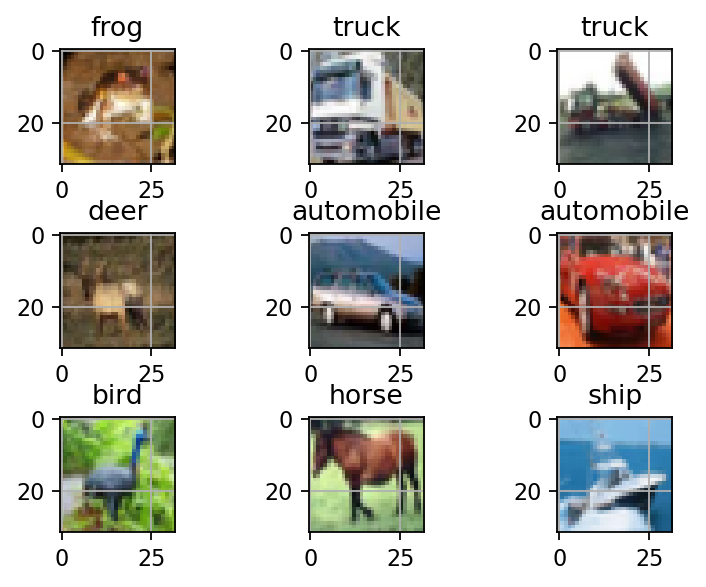

In [14]:
z = model.predict(x_test)

plot_images(x_test, z)

### Сегментация

![](img/hard/image-segmentation.jpg)

#### SegNet

![](img/hard/segnet.png)

#### U-net

![](img/hard/u-net.png)

### Локализация

![](img/hard/object-dectection.webp)

#### YOLO

![](img/hard/yolo.jpeg)

## Transfer Learning

![](img/hard/transfer-learning.png)

## Generative Adversarial Network's

![](img/hard/gan.jpg)

## Все еще актуально

![wanted](img/soft/wanted-ds.png)

## Вопросы